# ENSEMBLE MODEL: VARIOUS TYPE

Menggabungkan beberapa algoritma yang berbeda:
- Voting
- Stacking


In [23]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt

# train test split
from sklearn.model_selection import train_test_split

# impute missing values
from sklearn.impute import SimpleImputer # mean, median, most_frequent (mode), constant
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer # regresi
from sklearn.impute import KNNImputer # regresi KKN

# encoding
from sklearn.preprocessing import OneHotEncoder
from category_encoders import OrdinalEncoder, BinaryEncoder

# scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler 

# column transformer & pipeline
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline

# cross validation
from sklearn.model_selection import cross_val_score

# algorithm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# metric
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 

# hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [12]:
from sklearn.preprocessing import PolynomialFeatures

## **1. load dataset**

In [13]:
# load dataset
df = pd.read_csv('white_wine.csv')[['density', 'alcohol', 'quality']]
df.head() 

,density,alcohol,quality
0,1.0010,8.8,6.0
1,0.9940,9.5,6.0
2,0.9951,10.1,6.0
3,0.9956,9.9,6.0
4,0.9956,9.9,6.0


In [14]:
# quality > 6 adalah kelas 1
# quality <= 6 adalah kelas 0

df['quality'] = np.where(df['quality']>6, 1, 0)
df.head()

,density,alcohol,quality
0,1.0010,8.8,0
1,0.9940,9.5,0
2,0.9951,10.1,0
3,0.9956,9.9,0
4,0.9956,9.9,0


In [15]:
df.isna().sum()

density    0
alcohol    1
quality    0
dtype: int64

In [16]:
df = df.dropna()
df.shape 

(519, 3)

In [17]:
df = df.drop_duplicates()
df.shape 

(368, 3)

## **2. EDA**

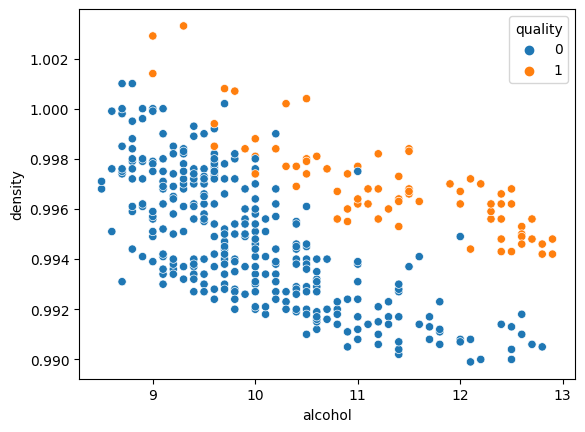

In [18]:
sns.scatterplot(data=df, x='alcohol', y='density', hue='quality');

## **3. Define X y**

In [19]:
# Define X y
X = df.drop(columns='quality')
y = df['quality']

In [20]:
y.value_counts() / len(y)
# imbalance

quality
0    0.80163
1    0.19837
Name: count, dtype: float64

## **4. Data Splitting**

In [21]:
# Data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)

In [22]:
from sklearn.metrics import f1_score

## **5. Preprocessing**

In [24]:
# define polynomial
poly = PolynomialFeatures(degree=3)

In [25]:
# Pipeline poly + scaling

pipe_poly_scaling = Pipeline([
    ('poly', PolynomialFeatures(degree=3)),
    ('scaling', RobustScaler())
])

In [26]:
transformer = ColumnTransformer([
    ('pipe_poly_scaling', pipe_poly_scaling, ['alcohol', 'density'])
], remainder='passthrough')

In [27]:
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipe_poly_scaling',
                                 Pipeline(steps=[('poly',
                                                  PolynomialFeatures(degree=3)),
                                                 ('scaling', RobustScaler())]),
                                 ['alcohol', 'density'])])

## **6. Cross Validation**

In [28]:
from sklearn.ensemble import VotingClassifier, StackingClassifier

In [54]:
logreg = LogisticRegression(random_state=0)
knn = KNeighborsClassifier(n_neighbors=5)
tree = DecisionTreeClassifier(random_state=0,max_depth=4)

In [55]:
# Voting
voting = VotingClassifier(estimators=[
    ('clf1', logreg),
    ('clf2', knn),
    ('clf3', tree)
])

voting

VotingClassifier(estimators=[('clf1', LogisticRegression(random_state=0)),
                             ('clf2', KNeighborsClassifier()),
                             ('clf3',
                              DecisionTreeClassifier(max_depth=4,
                                                     random_state=0))])

In [56]:
# stacking

stacking = StackingClassifier(
    estimators= [
        ('clf1', logreg),
        ('clf2', knn),
        ('clf3', tree)
    ],
    final_estimator= logreg
)

stacking


StackingClassifier(estimators=[('clf1', LogisticRegression(random_state=0)),
                               ('clf2', KNeighborsClassifier()),
                               ('clf3',
                                DecisionTreeClassifier(max_depth=4,
                                                       random_state=0))],
                   final_estimator=LogisticRegression(random_state=0))

In [69]:
# kandidat model
list_model = [logreg, knn, tree, voting, stacking]
name_list_model = ['logreg', 'knn', 'tree', 'voting', 'stacking']

list_all = []
list_mean = []
list_std = []

for model in list_model:
    pipe_model = Pipeline([
        ('preprocessing', transformer),
        ('modeling', model)
    ])

    cv_score = cross_val_score(
        estimator=pipe_model,
        X=X_train,
        y=y_train,
        cv = 5,
        scoring='f1'
    )

    list_all.append(cv_score.round(2))
    list_mean.append(cv_score.round(2).mean())
    list_std.append(cv_score.round(2).std())

In [70]:
df_cv = pd.DataFrame()
df_cv['Algorithm'] = name_list_model
df_cv['mean-F1 Score'] = list_mean
df_cv['std'] = list_std
df_cv['all'] = list_all
df_cv

,Algorithm,mean-F1 Score,std,all
0,logreg,0.874,0.076837,"[0.96, 0.73, 0.88, 0.9, 0.9]"
1,knn,0.878,0.054918,"[0.91, 0.83, 0.8, 0.9, 0.95]"
2,tree,0.872,0.052688,"[0.82, 0.92, 0.83, 0.95, 0.84]"
3,voting,0.906,0.024166,"[0.91, 0.88, 0.89, 0.95, 0.9]"
4,stacking,0.884,0.056780,"[0.91, 0.78, 0.88, 0.95, 0.9]"


## **7. Cross Validation**

In [71]:
# Voting
voting = VotingClassifier(estimators=[
    ('clf1', logreg),
    ('clf2', knn),
    ('clf3', tree)
])

voting

VotingClassifier(estimators=[('clf1', LogisticRegression(random_state=0)),
                             ('clf2', KNeighborsClassifier()),
                             ('clf3',
                              DecisionTreeClassifier(max_depth=4,
                                                     random_state=0))])

In [83]:
#Untuk Estimator

pipe_model = Pipeline([
        ('preprocessing', transformer),
        ('modeling', model)
    ])

#untuk param+gtid
hyperparam = {
    'modeling__clf1__C':[1000,100,10,1,0.1,0.01,0.001], #hyperparam untuk log reg #Flatting linear line agar lebih tergenalisir sehingga tidak terjadi overfitting (dekat dengan y test)
    'modeling__clf2__n_neighbors':np.arange(3,11,2), #hyperparam untuk knn
    'modeling__clf3__max_depth': np.arange(1,11,1),
    'modeling__clf3__min_samples_split': np.arange(2,20,2) #hyperparam untuk dec tree
}

grid = GridSearchCV(
    estimator=pipe_model,
    param_grid= hyperparam,
    cv=5,
    scoring='f1',
    n_jobs= -1
)

In [84]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('pipe_poly_scaling',
                                                                         Pipeline(steps=[('poly',
                                                                                          PolynomialFeatures(degree=3)),
                                                                                         ('scaling',
                                                                                          RobustScaler())]),
                                                                         ['alcohol',
                                                                          'density'])])),
                                       ('modeling',
                                        StackingClassifier(estimators=[('clf1',
                                                                        LogisticRegression(random_state=0)),
                                                                       ('clf2',
                                                                        KNeighbo...
                                                                        DecisionTreeClassifier(max_depth=4,
                                                                                               random_state=0))],
                                                           final_estimator=LogisticRegression(random_state=0)))]),
             n_jobs=-1,
             param_grid={'modeling__clf1__C': [1000, 100, 10, 1, 0.1, 0.01,
                                               0.001],
                         'modeling__clf2__n_neighbors': array([3, 5, 7, 9]),
                         'modeling__clf3__max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'modeling__clf3__min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18])},
             scoring='f1')

In [85]:
df_grid = pd.DataFrame(grid.cv_results_).sort_values('rank_test_score')
df_grid.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_modeling__clf1__C,param_modeling__clf2__n_neighbors,param_modeling__clf3__max_depth,param_modeling__clf3__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1792,0.160018,0.008226,0.017581,0.004290,0.1,9,10,4,"{'modeling__clf1__C': 0.1, 'modeling__clf2__n_...",0.956522,0.833333,0.888889,1.0,0.952381,0.926225,0.058425,1
2512,0.185974,0.022047,0.018278,0.005807,0.001,9,10,4,"{'modeling__clf1__C': 0.001, 'modeling__clf2__...",0.956522,0.833333,0.888889,1.0,0.952381,0.926225,0.058425,1
2152,0.156465,0.009970,0.017754,0.005403,0.01,9,10,4,"{'modeling__clf1__C': 0.01, 'modeling__clf2__n...",0.956522,0.833333,0.846154,1.0,0.952381,0.917678,0.065909,3
2503,0.159260,0.012755,0.018557,0.004243,0.001,9,9,4,"{'modeling__clf1__C': 0.001, 'modeling__clf2__...",0.909091,0.833333,0.888889,1.0,0.952381,0.916739,0.056557,4
1783,0.157852,0.009376,0.013306,0.001502,0.1,9,9,4,"{'modeling__clf1__C': 0.1, 'modeling__clf2__n_...",0.909091,0.833333,0.888889,1.0,0.952381,0.916739,0.056557,4


In [86]:
X_train

,density,alcohol
374,0.9943,12.5
18,0.9917,11.3
476,0.9943,12.4
327,0.9944,10.0
259,0.9904,11.4
...,...,...
286,0.9978,9.7
101,0.9962,9.4
64,0.9927,10.3
484,0.9954,9.6
